In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mic-weekly-contest-week-1/dataset/test/208.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/473.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/333.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/45.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/369.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/56.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/89.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/20.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/275.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/212.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/239.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/58.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/150.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/6.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/109.jpg
/kaggle/input/mic-weekly-contest-week-1/dataset/test/149.jpg
/kaggle/input/mic-weekly-contes

In [2]:
import torch
from PIL import Image
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import multiprocessing
from tqdm.notebook import tqdm
import os

In [3]:
train_count= 0 
test_count= 0  

for filename in os.listdir('/kaggle/input/mic-weekly-contest-week-1/dataset/train'):
    train_count+=1 
for filename in os.listdir('/kaggle/input/mic-weekly-contest-week-1/dataset/test'):
    test_count+=1

print("Number of train images : ",train_count)
print("Number of test images : ",test_count)

Number of train images :  2975
Number of test images :  500


In [4]:
import tensorflow as tf
from tensorflow.keras import layers,models
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

In [8]:
train_img_path = os.listdir('/kaggle/input/mic-weekly-contest-week-1/dataset/train')
test_img_path= os.listdir('/kaggle/input/mic-weekly-contest-week-1/dataset/test')

In [7]:
class ImageDataset(Dataset):
    def __init__(self, split, files, transform):
        self.split = split
        self.files = files
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self, idx):
        img = Image.open(f"/kaggle/input/mic-weekly-contest-week-1/dataset/{self.split}/{self.files[idx]}")
        x_img = np.array(img)[:,:256]
        y_img = np.array(img)[:,256:]
        x_img = self.transform(x_img)
        y_img = self.to_tensor(y_img)
        return x_img, y_img
        
    def __len__(self):
        return len(self.files)

In [9]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.3, 0.3, 0.3), (0.3, 0.3, 0.3))])

In [10]:
ds_train = ImageDataset("train", train_img_path, transform=trans)
ds_test = ImageDataset("val", test_img_path, transform=trans)

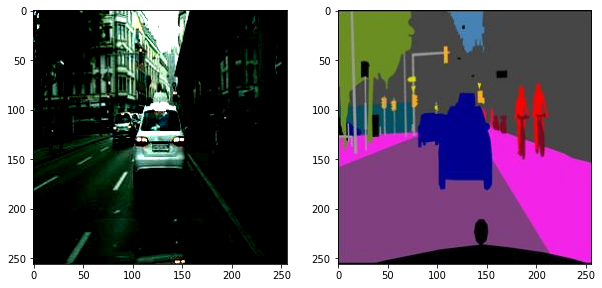

In [11]:
img, labels_rgb = ds_train[10]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0).numpy())
ax[1].imshow(labels_rgb.permute(1, 2, 0).numpy())
plt.show()

In [13]:
BATCH_SIZE = 32
EPOCHS = 7

train_loader = DataLoader(ds_train, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=multiprocessing.cpu_count())
val_loader = DataLoader(ds_test, 
                          batch_size=BATCH_SIZE, 
                          num_workers=multiprocessing.cpu_count())

In [14]:
class DualConv3x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = F.relu(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.dual_conv = DualConv3x3(in_channels, out_channels)
        self.pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

    def forward(self, x):
        skip = self.dual_conv(x)
        out = self.pooling(skip)
        return out, skip
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(2, 2), stride=2)
        self.dual_conv = DualConv3x3(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up_conv(x)
        x = torch.cat((skip, x), dim=1)
        x = self.dual_conv(x)
        return x

class UNetEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = EncoderBlock(in_channels, 64)
        self.b2 = EncoderBlock(64, 128)
        self.b3 = EncoderBlock(128, 256)
        self.b4 = DualConv3x3(256, 512)

    def forward(self, x):
        x, skip_1 = self.b1(x)
        x, skip_2 = self.b2(x)
        x, skip_3 = self.b3(x)
        x = self.b4(x)
        return x, [skip_1, skip_2, skip_3]

class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.b3 = DecoderBlock(512, 256)
        self.b2 = DecoderBlock(256, 128)
        self.b1 = DecoderBlock(128, 64)
        
    def forward(self, x, skip_conns):
        x = self.b3(x, skip_conns[-1])
        x = self.b2(x, skip_conns[-2])
        x = self.b1(x, skip_conns[-3])
        return x
class UNet(nn.Module):
    """ U-Net as proposed in https://arxiv.org/pdf/1505.04597.pdf with
    3 downsampling operations instead of 4 due to memory restrictions.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = UNetEncoder(in_channels)
        self.decoder = UNetDecoder()
        self.conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)
        
    def forward(self, x):
        x, skip_connections = self.encoder(x)
        x = self.decoder(x, skip_connections)
        x = self.conv(x)
        x = torch.sigmoid(x)
        return x

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
model = UNet(3, 3)
model.to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [ ]:
train_losses = []
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_train_losses = []
    for x, y in tqdm(train_loader):
        optim.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optim.step()
        running_train_losses.append(loss.item())
    train_loss = np.mean(running_train_losses)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}/{EPOCHS} => train_loss: {train_loss}")

  0%|          | 0/93 [00:00<?, ?it/s]

In [ ]:
x_val, y_val = ds_test[0]
x_val = x_val.to(device)
model.eval()
with torch.no_grad():
    y_pred = model(x_val.unsqueeze(0)).squeeze(0).detach()

x_val = x_val.cpu()
y_pred = y_pred.cpu()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(x_val.permute(1, 2, 0).numpy())
ax[0].set_title("Original")
ax[1].imshow(y_pred.permute(1, 2, 0).numpy())
ax[1].set_title("Predicted mask")
ax[2].imshow(y_val.permute(1, 2, 0).numpy())
ax[2].set_title("True mask")
plt.show()